In [1]:
# All resources can be downloaded from http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/
# Most of implementaion is from https://github.com/tkarras/progressive_growing_of_gans/blob/master/dataset_tool.py

In [2]:
import os
import PIL
import pandas as pd
import numpy as np
from scipy import ndimage

BB_LANDMARK_DIR = './dataset/VGGFACE2/bb_landmark/'
TRAININGSET_DIR = './dataset/VGGFACE2/train/'
TESTSET_DIR = './dataset/VGGFACE2/test/'

assert(os.path.isdir(BB_LANDMARK_DIR))
loose_bb_test = pd.read_csv(BB_LANDMARK_DIR+'loose_bb_test.csv', header=None)
loose_landmark_test = pd.read_csv(BB_LANDMARK_DIR+'loose_landmark_test.csv', header=None)

print(loose_bb_test)
print(loose_landmark_test)

/Users/jinwoopark/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


                      0    1    2    3    4
0               NAME_ID    X    Y    W    H
1       n000001/0001_01   60   60   79  109
2       n000001/0002_01  134   81  207  295
3       n000001/0003_01   58   32   75  103
4       n000001/0004_01  194   75  284  388
5       n000001/0005_01   51   50   77  100
6       n000001/0006_01  243  106  455  602
7       n000001/0007_01  173   78  214  303
8       n000001/0008_01   98   29  122  173
9       n000001/0009_01  158  110  227  311
10      n000001/0010_01  111   -2  154  207
11      n000001/0011_01  185  104  248  334
12      n000001/0012_01   82   87  111  147
13      n000001/0013_01   73   68  174  234
14      n000001/0014_01   74   46  115  155
15      n000001/0015_01  107   47  149  203
16      n000001/0016_01   91   44  143  187
17      n000001/0017_01  152  117  227  308
18      n000001/0018_01   77   59  123  167
19      n000001/0019_01  154   69  209  301
20      n000001/0020_01   87   55  109  158
21      n000001/0021_01   86   6

/Users/jinwoopark/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
IMGDIR = TESTSET_DIR
LOOSE_LANDMARKS = loose_landmark_test
RESOLUTION = 256

def rot90(v):
    return np.array([-v[1], v[0]])

def process_func(idx):
    # load original image
    img_name = LOOSE_LANDMARKS[0][idx]
    left_eye = LOOSE_LANDMARKS.T[idx][1:].values[0:2].astype('float32')
    right_eye = LOOSE_LANDMARKS.T[idx][1:].values[2:4].astype('float32')
    left_mouth = LOOSE_LANDMARKS.T[idx][1:].values[6:8].astype('float32')
    right_mouth = LOOSE_LANDMARKS.T[idx][1:].values[8:].astype('float32')
    img = PIL.Image.open(IMGDIR+img_name+'.jpg')
    
    # Choose oriented crop rectangle.
    eye_avg = (left_eye + right_eye) * 0.5 + 0.5
    mouth_avg = (left_mouth + right_mouth) * 0.5 + 0.5
    eye_to_eye = right_mouth - left_mouth
    eye_to_mouth = mouth_avg - eye_avg
    x = eye_to_eye - rot90(eye_to_mouth)
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = rot90(x)
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    zoom = RESOLUTION / (np.hypot(*x) * 2)
    
    # Shrink.
    shrink = int(np.floor(0.5 / zoom))
    if shrink > 1:
        size = (int(np.round(float(img.size[0]) / shrink)), int(np.round(float(img.size[1]) / shrink)))
        img = img.resize(size, PIL.Image.ANTIALIAS)
        quad /= shrink
        zoom *= shrink
    
    # Crop.
    border = max(int(np.round(RESOLUTION * 0.1 / zoom)), 3)
    crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]
        
    # Simulate super-resolution.
    superres = int(np.exp2(np.ceil(np.log2(zoom))))
    if superres > 1:
        img = img.resize((img.size[0] * superres, img.size[1] * superres), PIL.Image.ANTIALIAS)
        quad *= superres
        zoom /= superres
        
    # Pad.
    pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
    if max(pad) > border - 4:
        pad = np.maximum(pad, int(np.round(RESOLUTION * 0.3 / zoom)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.mgrid[:h, :w, :1]
        mask = 1.0 - np.minimum(np.minimum(np.float32(x) / pad[0], np.float32(y) / pad[1]), np.minimum(np.float32(w-1-x) / pad[2], np.float32(h-1-y) / pad[3]))
        blur = RESOLUTION * 0.02 / zoom
        img += (ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.round(img), 0, 255)), 'RGB')
        quad += pad[0:2]
            
    # Transform.
    img = img.transform((RESOLUTION*4, RESOLUTION*4), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    img = img.resize((RESOLUTION, RESOLUTION), PIL.Image.ANTIALIAS)
    #img = np.asarray(img).transpose(2, 0, 1)
    
    return img

n000706/0498_02


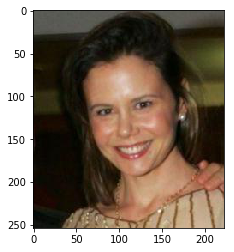

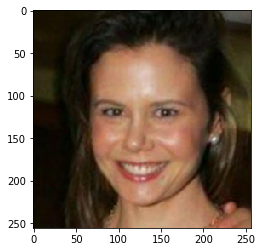

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

idx = 10000
img_name = loose_landmark_test[0][idx]
print(img_name)

assert(os.path.isdir(IMGDIR))
orig_img = PIL.Image.open(IMGDIR+img_name+'.jpg')
plt.figure()
plt.imshow(orig_img)

processed_img = process_func(idx)
plt.figure()
plt.imshow(processed_img)